## script to load dataset for the first mouse without daily paired spontaneous imaging sessions

In [141]:
# script to convert the uploaded dataset into request format for training

In [142]:
import os
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy import stats
import copy
import random

In [143]:


LoadDatafile = "/Users/Erfan/Desktop/Representational Drift/Ca1 Xin Data /WeekLearningData.npz"

with np.load(LoadDatafile,allow_pickle=True) as data:
    AllSerialdffData = data['AlltaskdffSerial'][()]
    AllVRonPeriodData = data['VRonPeriodData'][()]
    AllContextWiseBehav = data['AllContextWiseBehav'][()]
    AllPairTVDatas = data['AllPairTVDatas'][()]
    PairedSessDays = data['PairedSessDays'][()]
    AllpairIsPC = data['PairedIndsIsPC'][()]
    UsedDayStr = data['PairedSessDays'][()]
    SponLastSess_serialDff = data['SponSessDffTrace'][()]
    SponBehavSerials = data['SponBehavSerial'][()]
    
#############
# Including the spatial lcoation datas in the dataset
LoadDatafile2 = "/Users/Erfan/Desktop/Representational Drift/Ca1 Xin Data /WeekLearningData_ROIloc.npz"
# np.savez(Savefile2,AllSessROIcents = AllPairROIcents,AllSessROIPixels=AllPairROIpixels,
#          UsedPairIndex=UsedSess_indexPair,AllpairFOVims = AllPairSessImage)
with np.load(LoadDatafile2,allow_pickle=True) as data2:
    AllPairROIcenter = data2['AllSessROIcents'][()] # this contains the center loc for all ROIs, each 
    AllPairROIpixels = data2['AllSessROIPixels'][()]
    

Save the smaller data

In [151]:
# ============================================================
#  SAVE A COMPACT SUBSET FOR DESTINODE DEBUGGING
# ============================================================
import numpy as np, pathlib

# ---------------- user knobs ----------------
LOAD_MAIN   = pathlib.Path("/Users/Erfan/Desktop/Representational Drift/Ca1 Xin Data /WeekLearningData.npz")
LOAD_ROI    = pathlib.Path("/Users/Erfan/Desktop/Representational Drift/Ca1 Xin Data /WeekLearningData_ROIloc.npz")

SAVE_FILE   = pathlib.Path("destin_debug_subset.npz")   # will be ~10‑20 MB
SESS_KEEP   = None          # None = keep *all* sessions, or e.g. [0,1,2]
MAX_ROIS    = 400           # None = all ROIs, or an int to cap per session
USED_CONTEXTS = {0}         # which contexts to *keep*  (after mapping)
# -----------------------------------------------------------

# ---------- load full arrays ----------
with np.load(LOAD_MAIN, allow_pickle=True) as data:
    AllSerialdffData  = data['AlltaskdffSerial'][()]
    AllVRonPeriodData = data['VRonPeriodData'][()]

with np.load(LOAD_ROI, allow_pickle=True) as data2:
    AllPairROIcenter  = data2['AllSessROIcents'][()]

T_full = len(AllSerialdffData)
if SESS_KEEP is None:
    SESS_KEEP = list(range(T_full))

# ---------- mapping: boundary‑segment → context ID ----------
#      Adjust *per session* if the order differs across days.
DEFAULT_SEG2CTX = np.array([0, 1, 0, 2])  # [c0, c1, c0, c2]

# ---------- collect & save ----------
subset = {}
for t in SESS_KEEP:
    serial = AllSerialdffData[t]
    perf   = AllVRonPeriodData[t]

    vr_on_mask = serial[1].astype(bool)

    dff = serial[0][:MAX_ROIS, :][:, vr_on_mask].astype(np.float32)
    pos = serial[3][vr_on_mask].astype(np.float32)
    vel = serial[4][vr_on_mask].astype(np.float32)

    lap_idx_frame = perf[4]       # len == K_vr

    # ---------- boundaries → per‑lap context ----------
    boundaries = perf[6]          # e.g. [ 0 15 30 45 60 ]
    n_segments = len(boundaries) - 1

    # session‑specific mapping (edit as needed)
    SESSION_SEG2CTX = {
        0: [0, 1, 0, 2],   # Day 1
        1: [0, 1, 0, 2],   # Day 2
        2: [0, 1, 0, 2],   # …
        3: [0, 1, 0, 2],
        4: [0, 1, 0, 2],
        5: [0, 1, 0, 2],
        6: [0, 1, 0, 2],
        7: [0, 1, 0, 2], 
    }
    SESSION_SEG2CTX.update({
    4: [0,1,0,2,1],
    5: [0,1,0,2,1],
    7: [0,1,0,2,1],
    })
    seg2ctx = np.array(SESSION_SEG2CTX[t])

    if len(seg2ctx) != n_segments:
        print(f"WARNING  session {t}: seg2ctx len {len(seg2ctx)} "
            f"≠ #segments {n_segments}  — skipped")
        continue

    # length must cover the largest lap index we actually see
    n_laps_tot = lap_idx_frame.max() + 1
    lap_ctx_perlap = np.empty(n_laps_tot, dtype=np.int8)

    for seg in range(n_segments):
        lap_start, lap_end = boundaries[seg], boundaries[seg+1]
        lap_ctx_perlap[lap_start:lap_end] = seg2ctx[seg]

    lap_ctx_frame = lap_ctx_perlap[lap_idx_frame]

    # ---------- keep only desired contexts ----------
    keep_mask = np.isin(lap_ctx_frame, list(USED_CONTEXTS))
    if not keep_mask.any():
        print(f"Session {t}: no frames with contexts {USED_CONTEXTS} — skipped")
        continue

    dff, pos, vel, lap_idx_frame, lap_ctx_frame = (
        dff[:, keep_mask],
        pos[keep_mask],
        vel[keep_mask],
        lap_idx_frame[keep_mask],
        lap_ctx_frame[keep_mask],
    )

    roi_centers = AllPairROIcenter[t][:MAX_ROIS].astype(np.int16)

    # ---------- store ----------
    subset[f'dff_{t}']         = dff
    subset[f'pos_{t}']         = pos
    subset[f'vel_{t}']         = vel
    subset[f'lap_idx_{t}']     = lap_idx_frame.astype(np.int16)
    subset[f'lap_ctx_{t}']     = lap_ctx_frame.astype(np.int8)
    subset[f'roi_centers_{t}'] = roi_centers

    print(f"Session {t}: kept {len(np.unique(lap_idx_frame)):3d} laps "
        f"| {dff.shape[1]:5d} frames | contexts {np.unique(lap_ctx_frame)}")


np.savez_compressed(SAVE_FILE, **subset)
print(f"\nSubset written to {SAVE_FILE.absolute()}  "
      f"({SAVE_FILE.stat().st_size/1e6:.1f} MB)")


Session 0: kept  30 laps | 21710 frames | contexts [0]
Session 1: kept  30 laps | 29357 frames | contexts [0]
Session 2: kept  33 laps | 21224 frames | contexts [0]
Session 3: kept  33 laps | 20060 frames | contexts [0]
Session 4: kept  30 laps | 18603 frames | contexts [0]
Session 5: kept  30 laps | 21901 frames | contexts [0]
Session 6: kept  32 laps | 23185 frames | contexts [0]
Session 7: kept  30 laps | 19308 frames | contexts [0]

Subset written to /Users/Erfan/Documents/GitHub/RepDriftModel/DestinODE/destin_debug_subset.npz  (199.1 MB)


In [ ]:
# AllVRonPeriodData 
# AllPairTaskPerf.append([cTaskFramePos,cTaskFrameVelocity,cTaskFrameLicks,cTaskFramereward,cTaskFramelapIndex,
#                             cTasklaptypes,cTask_lapseclist])


In [ ]:
# AllPairTVDatas.shape
# for example, if you want the upper half of ROIs in session 1, you can simply use
UsedROIInds = AllPairROIcenter[0][:,0] <= 256 # because the frame size is 512

# # if use all ROIs, another simple way is to
# UsedROIInds = AllPairROIcenter[0][:,0] >= 0

# you can also use random half of the neurons for testing

# reconstruct the whole ROI masks for session 1
Sess1ROIpixels = AllPairROIpixels[0]
RawROImasks = np.zeros((512,512),dtype='float64')
RawROIIndex = np.zeros((512,512),dtype='float64')
MaskColorvalues = np.random.rand(len(Sess1ROIpixels))
for cR in range(len(Sess1ROIpixels)):
    cRpixels = Sess1ROIpixels[cR]
    numofPixels = len(cRpixels['xpix'])
    for cpixel in range(numofPixels):
        RawROImasks[cRpixels['ypix'][cpixel],cRpixels['xpix'][cpixel]] = MaskColorvalues[cR]
        RawROIIndex[cRpixels['ypix'][cpixel],cRpixels['xpix'][cpixel]] = cR

     

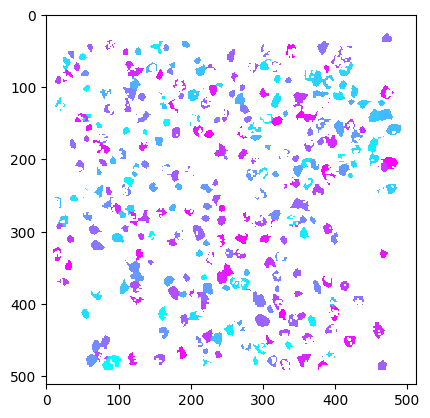

In [ ]:
masked_data = np.ma.masked_array(RawROImasks, mask=RawROIIndex==0)
plt.imshow(masked_data,vmin=0,vmax=1,cmap='cool')  

Current session is Day 1


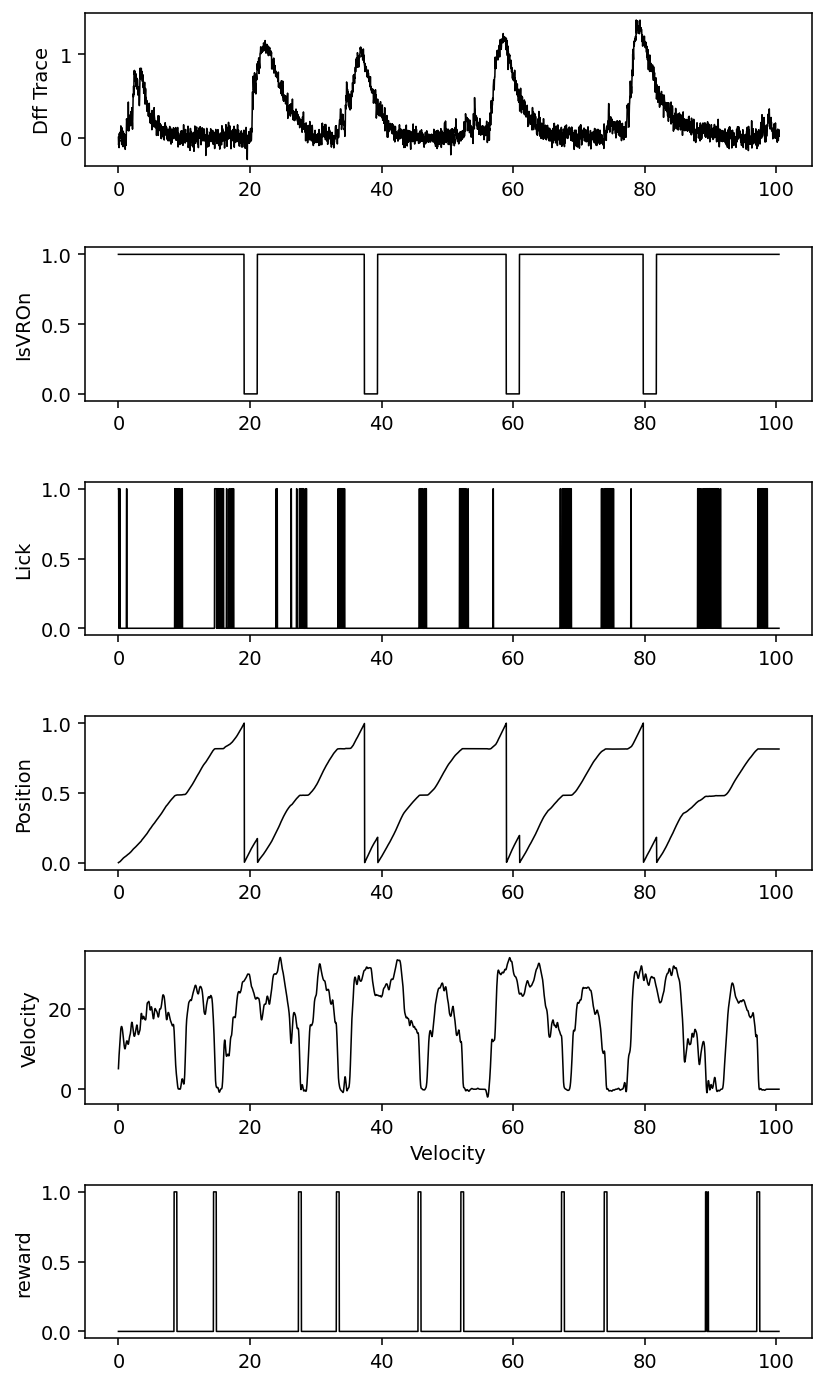

In [ ]:
# plot some basic properties of the animal behavior
fr = 29.8739

CheckSessIndex = 0
SessDayStr = PairedSessDays[CheckSessIndex]
print(f"Current session is Day {SessDayStr}")
cSessData = AllSerialdffData[CheckSessIndex]

PlotRange=3000 # only plot the first 3000 frametime events
Frametimes = np.arange(0,PlotRange)/fr
cDataStr = ["Dff Trace","IsVROn","Lick","Position","Velocity","reward"]
fig330, ax030 = plt.subplots(nrows=len(cDataStr), ncols=1, figsize=(6,10),dpi=140)
for cInds in range(6):
    cData = cSessData[cInds]
    if cData.ndim > 1:
        ax030[cInds].plot(Frametimes,cData[0,0:PlotRange],'k',lw=0.8) # plot the first ROI as example
    else:
        ax030[cInds].plot(Frametimes,cData[0:PlotRange],'k',lw=0.8)
    ax030[cInds].set_ylabel(cDataStr[cInds])
    if cInds == 4: # last plot add xlabel
        ax030[cInds].set_xlabel(cDataStr[cInds])

plt.tight_layout()

Current session is Spontaneous recording at Day 10


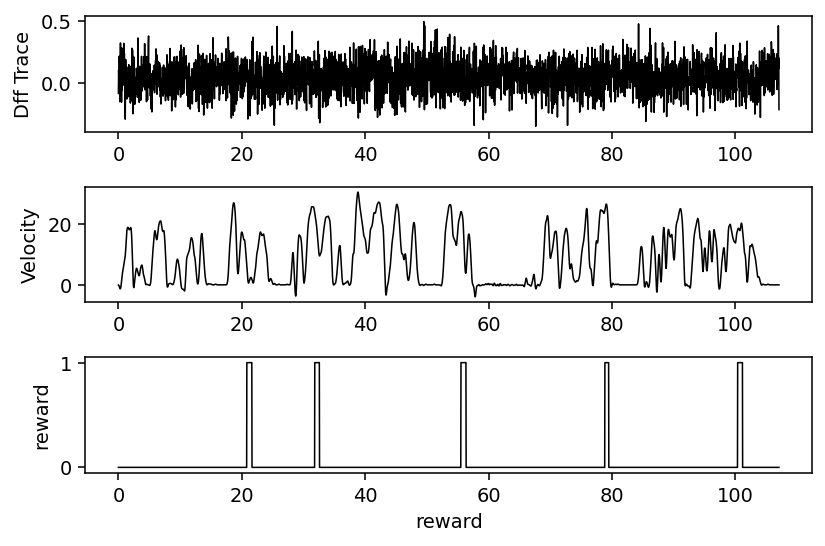

In [ ]:
# VR off Sponteneous conditions

fr = 29.8739

print(f"Current session is Spontaneous recording at Day 10")

PlotRange=3200 # only plot the first 3000 frametime events
Frametimes = np.arange(0,PlotRange)/fr
PlotDatas = [SponLastSess_serialDff,SponBehavSerials[0],SponBehavSerials[1]]
cDataStr = ["Dff Trace","Velocity","reward"]
Numofplots = len(PlotDatas)
fig3302, ax0302 = plt.subplots(nrows=Numofplots, ncols=1, figsize=(6,4),dpi=140)
for cInds in range(Numofplots):
    cData = PlotDatas[cInds]
    if cData.ndim > 1:
        ax0302[cInds].plot(Frametimes,cData[2,0:PlotRange],'k',lw=0.8) # plot the first ROI as example
    else:
        ax0302[cInds].plot(Frametimes,cData[0:PlotRange],'k',lw=0.8)
    ax0302[cInds].set_ylabel(cDataStr[cInds])
    if cInds == Numofplots-1: # last plot add xlabel
        ax0302[cInds].set_xlabel(cDataStr[cInds])

plt.tight_layout()

In [ ]:
# constructing current dataset into requested format
# T = sessions (days)
# S =  trials per session
# K =  time bins per trial
# N =  neurons (half neurons)
# x: neural activity
#  shape: [T, S, K, N]
# v: animal velocity
#  shape: [T, S, K]
# u: animal position (target)
# shape: [T, S, K]
# W0: initial connectivity
# shape: [N, N] 

## trail equals to lap in all contents ##

# AllPairedSerialData.append([SerialdffTrace,cTaskVROnFrames,cSessTaskparas['licking'],
#                                cSessTaskparas['treadmillPosition'],cSessTaskparas['velocity'],cSessTaskparas['reward'],
#                                 cTask_lapseclist,cSessTaskparas['lap_bin']])
# AllPairTaskPerf.append([cTaskFramePos,cTaskFrameVelocity,cTaskFrameLicks,cTaskFramereward,cTaskFramelapIndex,
#                             cTasklaptypes,cTask_lapseclist])

MaxlapIndex = 15 # used to define what are the laps (trials) will be used. If you want to use all laps, just set it to a high number (e.g. 200)
NumSessions = len(AllSerialdffData)
print(f"Current session have {NumSessions} sessions.")

# each trial will have different length of time bin, you can use this to append the time bin dimension to max
TrialTimeBinLen = []

x = []
v = []
u = []

for cSess in range(NumSessions):
    # cDataStr = ["Dff Trace","IsVROn","Lick","Position","Velocity","reward"] # Serial data contents
    cSessSerialData = AllSerialdffData[cSess]
    cSessTaskPerf = AllVRonPeriodData[cSess]
    VROnFrames = cSessSerialData[1] # VR on frames indices
    # including VR-on frames only
    cSessdffTrace = cSessSerialData[0][UsedROIInds,:][:,VROnFrames] # Only includes used ROIs and VRon frames
    cSesspos = cSessSerialData[3][VROnFrames]
    cSessVelocity = cSessSerialData[4][VROnFrames]
    
    cSesslapIndex = cSessTaskPerf[4]
    usedlapInds = cSesslapIndex < MaxlapIndex
    cusedlapIndex = cSesslapIndex[usedlapInds]
    
    S = np.max(cSesslapIndex[usedlapInds])
    cSesstrbinlen = []
    cSess_dffTrace = []
    cSess_Velocity = []
    cSess_position = []
    for ctrial in range(S+1):
        ctrial_inds = cusedlapIndex == ctrial
        cTrial_dffTrace = cSessdffTrace[:,usedlapInds][:,ctrial_inds] # current trial data, in a shape of N by K
        cTrial_Velocity = cSessVelocity[usedlapInds][ctrial_inds]
        cTrial_position = cSesspos[usedlapInds][ctrial_inds]
        
        cSesstrbinlen.append(len(cTrial_Velocity))
        cSess_dffTrace.append(cTrial_dffTrace.T) # convert into a shape of K by N
        cSess_Velocity.append(cTrial_Velocity)
        cSess_position.append(cTrial_position)
        
    TrialTimeBinLen.append(cSesstrbinlen) # used to append the trial time bin to maximum len
    x.append(cSess_dffTrace)
    v.append(cSess_Velocity)
    u.append(cSess_position)
    

Current session have 8 sessions.


In [ ]:
# padding the trial time bins into maximum dimension ?


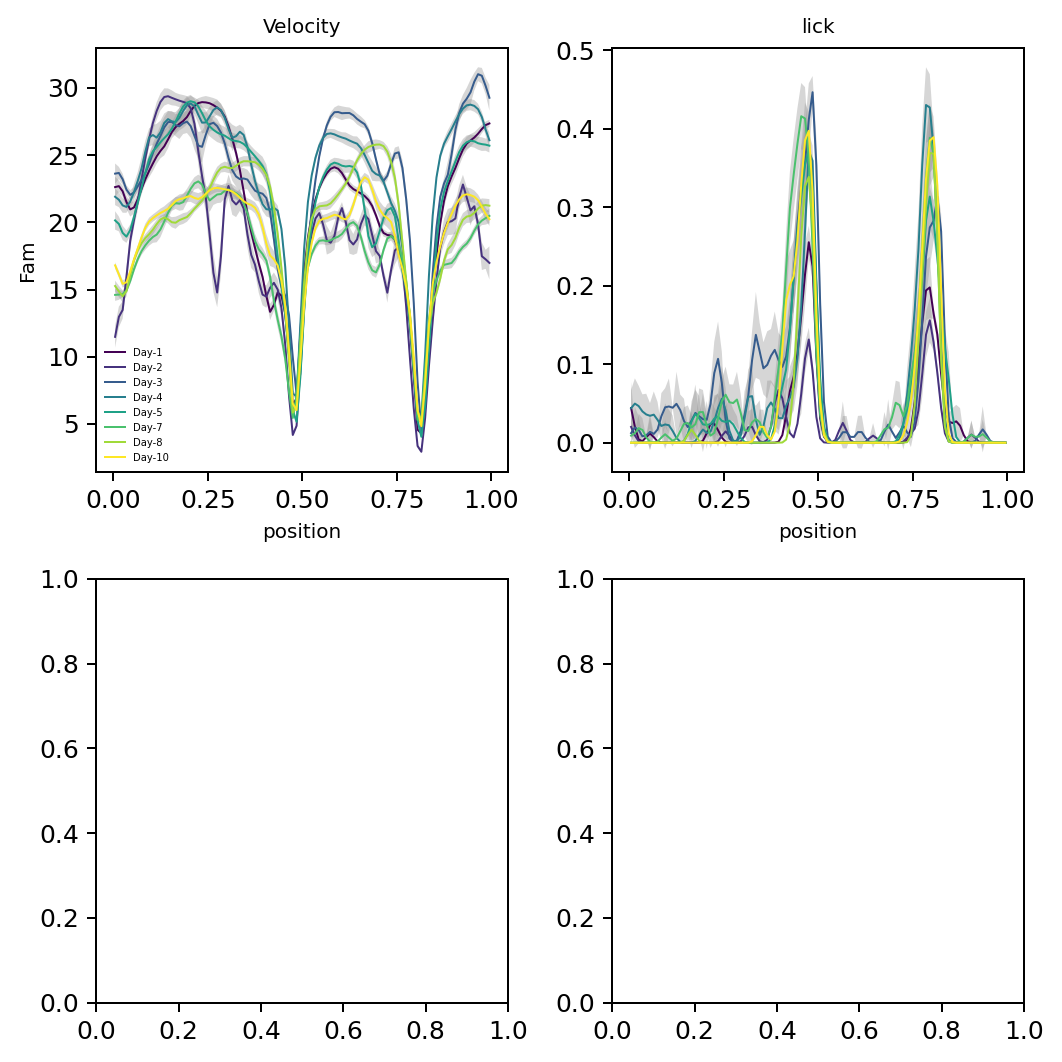

In [ ]:
# plt.plot(cTaskFramePos,cTaskFrameLicks,'ko',ms=1)
fig32, ax02 = plt.subplots(nrows=2, ncols=2, figsize=(6,6),dpi=180)
nBins = 100
LocBins = np.linspace(0.0,1.0,nBins+1)

cmap = plt.get_cmap('viridis')
laplineColors = cmap(np.linspace(0,1,len(PairedSessDays)))
spbincents = (LocBins[:-1]+LocBins[1:])/2

PlotData = 0 # 0 indicates Velocity, 1 indicates licks, 2 indicates reward
PlotDataStr = ['Velocity','lick']
cContext = 0
ContextStrs = ['Fam','Nov1','Fam','Nov2']
UsedInds = np.arange(0,len(PairedSessDays)).astype('int')

k = 0
for cData in range(2):
    for cContext in range(1):
        cax = ax02[cContext,cData]
        for Inds,Days in enumerate(UsedInds):
            cSessData = AllContextWiseBehav[Inds][cContext][cData]
            SmoothedTrace = gaussian_filter1d(cSessData[0],1)
            cax.fill_between(spbincents,SmoothedTrace-cSessData[1],SmoothedTrace+cSessData[1],
                        alpha=0.4,ec='none',fc=[0.6,0.6,0.6])
            cax.plot(spbincents,SmoothedTrace,lw=0.8,color=laplineColors[Inds],label=f"Day-{PairedSessDays[Inds]}")
        if cData%2 == 0:
            cax.set_title(f"{PlotDataStr[cData]}",fontsize=8)
            cax.set_ylabel(f"{ContextStrs[cContext]}",fontsize=8)
            cax.set_xlabel("position",fontsize=8)
        else:
            cax.set_title(f"{PlotDataStr[cData]}",fontsize=8)
            cax.set_xlabel("position",fontsize=8)
        k += 1
ax02[0,0].legend(fontsize=4,loc='best',shadow=None,frameon=False)
plt.tight_layout()

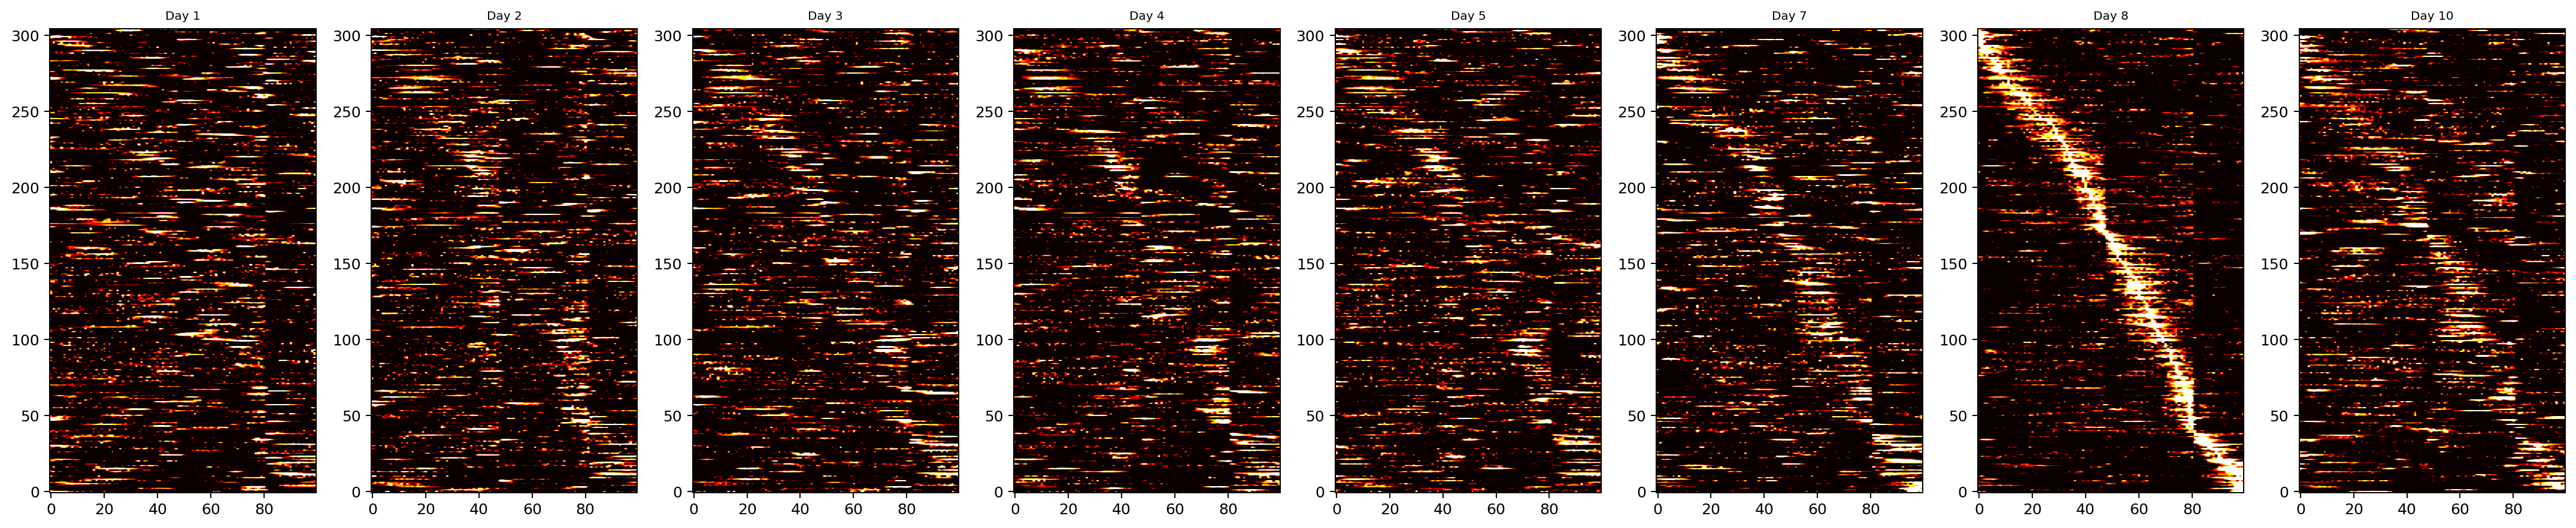

In [ ]:
UsedContext = 0
NumberofColumns = AllPairTVDatas.shape[3]

fig33, ax03 = plt.subplots(nrows=1, ncols=NumberofColumns, figsize=(3*NumberofColumns,5),dpi=180)
MaxValues = np.argmax(AllPairTVDatas[:,UsedContext,:,6],axis=1)
SortInds = np.argsort(MaxValues)[::-1]
for cSess in range(NumberofColumns):
    cSessData = AllPairTVDatas[:,UsedContext,:,cSess]
    NormData = stats.zscore(cSessData,axis=1)
    ax03[cSess].imshow(NormData[SortInds,:],vmin=0.6,vmax=2,aspect='auto',origin='lower',cmap='hot')
    ax03[cSess].set_title(f"Day {PairedSessDays[cSess]}",fontsize=8)
plt.tight_layout()

# the behavior performance changes during imaging

# pick out the stable cells, fraction of it
# detection of place field, stability of PF criteria

# activity during ITI
# raw time serial data and labeled ITI data




In [ ]:
RefSess=0
UsedContext = 0
AllCorr2Ref = []
AllShufCorrs = []

for UsedSess in range(NumberofColumns-1):
    A = AllPairTVDatas[:,UsedContext,:,RefSess]
    B = AllPairTVDatas[:,UsedContext,:,UsedSess+1]
    diag_pear_coef = np.array([stats.pearsonr(A[i, :], B[i, :])[0] for i in range(A.shape[0])])
    if len(AllCorr2Ref) == 0:
        AllCorr2Ref = diag_pear_coef[:,np.newaxis]
    else:
        AllCorr2Ref = np.concatenate((AllCorr2Ref,diag_pear_coef[:,np.newaxis]),axis=1)
    
    A_shuf = copy.copy(A)
    random.shuffle(A_shuf)
    # random_samples2 = random.choice(B.shape[0], size=1000)
    B_shuf = copy.copy(B)
    random.shuffle(B_shuf)

    for c in range(5):
        ShufNullCorrs = [stats.pearsonr(A_shuf[i, :], B_shuf[i, :])[0] for i in range(A_shuf.shape[0])]
        AllShufCorrs.extend(ShufNullCorrs)
    
# ShufNullCorrs = 

In [ ]:
shufCorrthreshold = np.percentile(AllShufCorrs,[95,99])
Mtx = AllCorr2Ref>shufCorrthreshold[0]
SigROIs = np.argwhere(np.sum(Mtx,axis=1)>=3)[:,0]
SigROIs
# plt.imshow(AllCorr2Ref>shufCorrthreshold[0],aspect='auto',vmin=0,vmax=1)

array([  0,   4,   8,   9,  10,  12,  13,  25,  27,  29,  30,  33,  38,
        44,  45,  47,  53,  63,  74,  88,  91,  98,  99, 100, 105, 106,
       110, 129, 167, 176, 185, 186, 188, 297, 302])

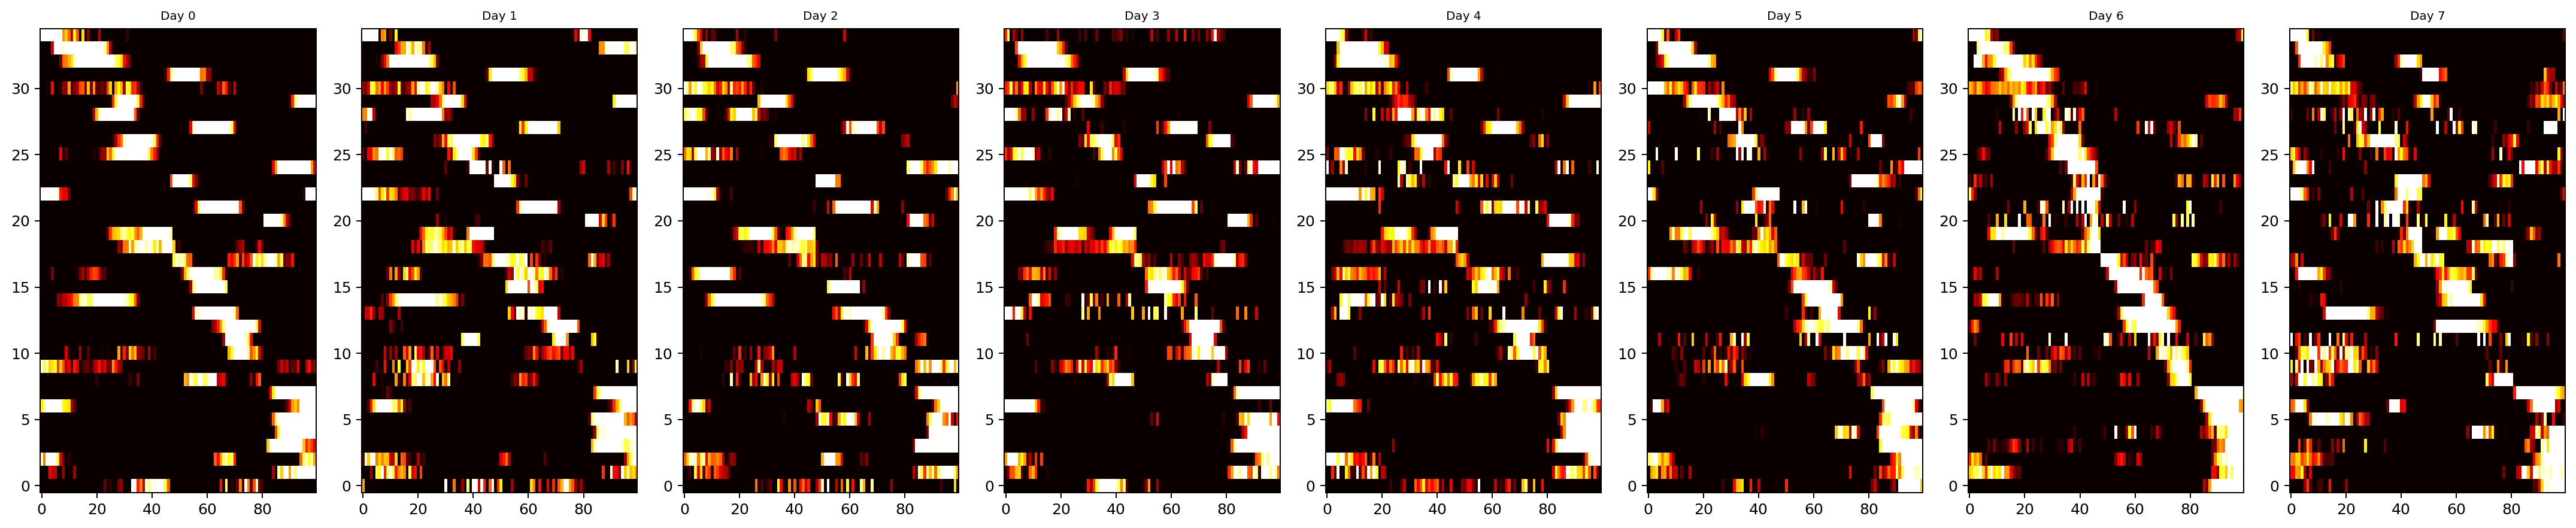

In [ ]:
UsedContext = 0
NumberofColumns = AllPairTVDatas.shape[3]

fig33, ax03 = plt.subplots(nrows=1, ncols=NumberofColumns, figsize=(3*NumberofColumns,5),dpi=180)
MaxValues = np.argmax(AllPairTVDatas[SigROIs,UsedContext,:,6],axis=1)
SortInds = np.argsort(MaxValues)[::-1]
for cSess in range(NumberofColumns):
    cSessData = AllPairTVDatas[SigROIs,UsedContext,:,cSess]
    NormData = stats.zscore(cSessData,axis=1)
    ax03[cSess].imshow(NormData[SortInds,:],vmin=0.6,vmax=1.6,aspect='auto',origin='lower',cmap='hot')
    ax03[cSess].set_title(f"Day {UsedInds[cSess]}",fontsize=8)
plt.tight_layout()

**DestinODE Compatible data**

In [ ]:
# ----------------------------------------------------------
#  DESTIN‑READY DATA (context‑0 only)  ✨ plug‑and‑play ✨
# ----------------------------------------------------------
import numpy as np, torch, scipy.io as sio
from pathlib import Path

# ---------- user knobs ----------
NPZ_MAIN      = Path("/Users/Erfan/Desktop/Representational Drift/Ca1 Xin Data /WeekLearningData.npz")
NPZ_ROI       = Path("/Users/Erfan/Desktop/Representational Drift/Ca1 Xin Data /WeekLearningData_ROIloc.npz")
USED_CONTEXT  = 0          # keep laps whose context == 0
MAX_LAP_IDX   = 200        # upper bound on laps to include
ROI_HALF      = "upper"    # 'upper', 'lower', or 'all'
# ---------------------------------

# ---------- load ----------
with np.load(NPZ_MAIN, allow_pickle=True) as D:
    AllSerialdffData = D['AlltaskdffSerial'][()]
    AllVRonPeriodData = D['VRonPeriodData'][()]

with np.load(NPZ_ROI, allow_pickle=True) as D2:
    AllPairROIcenter = D2['AllSessROIcents'][()]   # list‑of‑arrays, one per session

T = len(AllSerialdffData)

# ---------- choose ROIs ----------
UsedROIInds = []
for sess_cents in AllPairROIcenter:
    if ROI_HALF == "upper":
        UsedROIInds.append( np.where(sess_cents[:,0] <= 256)[0] )
    elif ROI_HALF == "lower":
        UsedROIInds.append( np.where(sess_cents[:,0] >  256)[0] )
    else:                      # 'all'
        UsedROIInds.append( np.arange(sess_cents.shape[0]) )

# ---------- per‑session extraction ----------
x_sess, v_sess, u_sess = [], [], []

for t in range(T):
    serial     = AllSerialdffData[t]
    perf       = AllVRonPeriodData[t]
    vr_frames  = serial[1]                        # indices where VR is ON

    # frame‑wise signals restricted to VR‑on
    dff        = serial[0][UsedROIInds[t], :][:, vr_frames]   # [N × K_tot]
    pos        = serial[3][vr_frames]                         # [K_tot]
    vel        = serial[4][vr_frames]                         # [K_tot]

    # lap_idx    = perf[4]              # per‑frame lap number
    # lap_ctx    = perf[5]              # per‑frame context ID  (0,1,…)

    # keep_mask  = (lap_idx < MAX_LAP_IDX) & (lap_ctx == USED_CONTEXT)
    #dff, pos, vel, lap_idx = dff[:, keep_mask], pos[keep_mask], vel[keep_mask], lap_idx[keep_mask]
    

    lap_idx_frame   = perf[4]          # shape [K_tot]  – lap number of every VR‑on frame
    lap_ctx_perlap  = perf[5]          # shape [S]      – one context label for each lap
    # map lap number → context label for every frame
    lap_ctx_frame   = lap_ctx_perlap[lap_idx_frame]    # shape [K_tot]
    keep_mask = (lap_idx_frame < MAX_LAP_IDX) & (lap_ctx_frame == USED_CONTEXT)
    
    dff, pos, vel, lap_idx_frame = (
    dff[:, keep_mask],
    pos[keep_mask],
    vel[keep_mask],
    lap_idx_frame[keep_mask])


    if dff.size == 0:        # nothing left after filtering
        print(f"Session {t}: no laps with context {USED_CONTEXT}")
        continue

    S_t = int(lap_idx.max()) + 1      # assumes laps are 0‑based & contiguous

    laps_x, laps_v, laps_u = [], [], []
    for s in range(S_t):
        mask = lap_idx == s
        if not mask.any():               # skip empty lap indices
            continue
        laps_x.append( dff[:, mask].T )  # -> K_s × N
        laps_v.append( vel[mask]   )     # -> K_s
        laps_u.append( pos[mask]   )     # -> K_s

    x_sess.append(laps_x)
    v_sess.append(laps_v)
    u_sess.append(laps_u)

# ---------- pad to rectangular tensors ----------
def pad_laps(laps, fill=0.0):
    K_max = max(l.shape[0] for l in laps)
    return np.stack([np.pad(l, ((0, K_max-l.shape[0]), (0, 0)) if l.ndim==2
                                else (0, K_max-l.shape[0]),
                             constant_values=fill)
                     for l in laps])          # -> [S_t, K_max, *]

x_padded, v_padded, u_padded, K_global = [], [], [], 0
for laps_x, laps_v, laps_u in zip(x_sess, v_sess, u_sess):
    X_pad = pad_laps(laps_x)
    V_pad = pad_laps([v[:,None] for v in laps_v]).squeeze(-1)
    U_pad = pad_laps([u[:,None] for u in laps_u]).squeeze(-1)
    K_global = max(K_global, X_pad.shape[1])
    x_padded.append(X_pad); v_padded.append(V_pad); u_padded.append(U_pad)

# second pass so every session has same K (pad right side)
def pad_K_global(arr, Kg, fill=0.0):
    pad = ((0,0), (0, Kg - arr.shape[1]), (0,)*(arr.ndim-2))
    return np.pad(arr, pad, mode='constant', constant_values=fill)

x_full = np.stack([pad_K_global(a, K_global) for a in x_padded])   # [T, S, Kg, N]
v_full = np.stack([pad_K_global(a, K_global) for a in v_padded])   # [T, S, Kg]
u_full = np.stack([pad_K_global(a, K_global) for a in u_padded])   # [T, S, Kg]

# ---------- torch tensors ----------
x_real = torch.tensor(x_full, dtype=torch.float32)
v_real = torch.tensor(v_full, dtype=torch.float32)
u_real = torch.tensor(u_full, dtype=torch.float32)

print("DESTIN‑ready shapes:", x_real.shape, v_real.shape, u_real.shape)


Session 0: no laps with context 0
Session 1: no laps with context 0
Session 2: no laps with context 0
Session 3: no laps with context 0
Session 4: no laps with context 0
Session 5: no laps with context 0
Session 6: no laps with context 0
Session 7: no laps with context 0


ValueError: need at least one array to stack

In [ ]:
# compare a random lap before/after
t, s = 0, 0
plt.imshow(x_real[t,s].cpu().T, aspect='auto', origin='lower', cmap='hot')
plt.title(f'Session {t} Lap {s}  (context {USED_CONTEXT})')
plt.xlabel('Time (K)'); plt.ylabel('Neuron');
plt.colorbar(); plt.show()


In [ ]:
#    x_real : [T  , S  , K  , N]   ΔF/F (time‑major, neuron‑last)
#    v_real : [T  , S  , K]        velocity
#    u_real : [T  , S  , K]        position  (optional, but included for completeness)
#
# NB: K is the *global* max‑frame‑count across all kept laps.


In [ ]:
x, v, u = x_real.to(device), v_real.to(device), u_real.to(device)
T_rec, S, K, N = x.shape
